# Sample a probability density with Neal's funnel using HMC

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from jax import jit, vmap, grad, hessian
import jax.numpy as jnp
import jax.random as jr
import jax.scipy as js

import numpyro
import numpyro.distributions as dist

from corner import corner

We model parameters $x$ and $y$. The likelihood is

\begin{equation*}
    p(d|x) \sim \mathcal{N}(\mu=3, \sigma=2)\;.
\end{equation*}

The priors are

\begin{align*}
    &p(x|y) \sim \mathcal{N}(\mu=0, \sigma=e^{y/2}) \\
    &p(y) \sim \mathcal{N}(\mu=0, \sigma=3)\;. \\
\end{align*}

Notice $y$ is a hyper-parameters in that the prior on $x$ is conditioned on $y$ - this is a hierarchical model. By Bayes' theorem, the posterior is

\begin{equation*}
    p(x, y | d) \propto p(d | x)\cdot p(x | y)\cdot p(y)\;.
\end{equation*}

In [2]:
# likelihood
@jit
def lnlike(x):
    return js.stats.norm.logpdf(x, loc=6., scale=2.)

# hyper-prior
@jit
def x_lnprior(x, y):
    return js.stats.norm.logpdf(x, loc=0., scale=jnp.exp(y / 2.))

# prior
@jit
def y_lnprior(y):
    return js.stats.norm.logpdf(y, loc=0., scale=3.)

# joint pdf
@jit
def joint_lnpdf(arr):
    x, y = arr
    return lnlike(x) + x_lnprior(x, y) + y_lnprior(y)

In [5]:
# normalize funnel for better sampling
def sampling_model():
    # sample from standard normal distribution
    x_normal = numpyro.sample('x_normal', dist.Normal(0.0, 1.0))
    y_normal = numpyro.sample('y_normal', dist.Normal(0.0, 1.0))

    # transform to prior distributions
    y = y_normal * 3.0
    x = x_normal * jnp.exp(y / 2)
    numpyro.deterministic('x', x)
    numpyro.deterministic('y', y)
    # y = numpyro.sample('y', dist.Normal(loc=0., scale=3.))
    # x = numpyro.sample('x', dist.Normal(loc=0., scale=jnp.exp(y / 2)))

    # likelihood factor
    numpyro.factor('lnlike', lnlike(x))

nuts_kernel = numpyro.infer.NUTS(model=sampling_model,
                                 dense_mass=False)
mcmc = numpyro.infer.MCMC(sampler=nuts_kernel,
                          num_warmup=int(1e4),
                          num_samples=int(1e5))
mcmc.run(jr.key(0))
samples_dict = mcmc.get_samples()
samples = np.array([samples_dict['x'], samples_dict['y']]).T

sample: 100%|██████████| 110000/110000 [00:16<00:00, 6547.19it/s, 15 steps of size 2.80e-01. acc. prob=0.84]


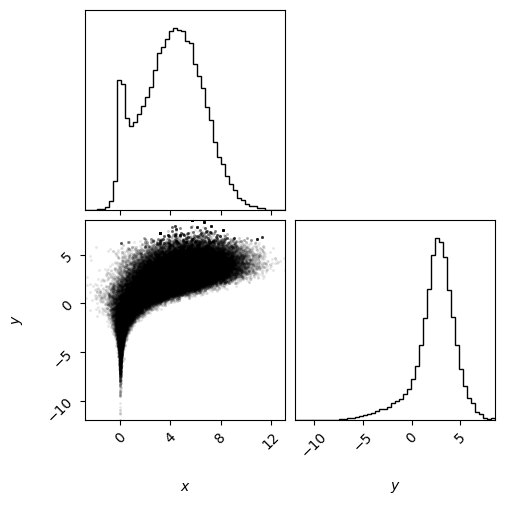

In [6]:
# plot funnel
labels = [r'$x$', r'$y$']
fig = corner(samples,
             bins=50,
             plot_contours=False,
             plot_density=False,
             labels=labels)

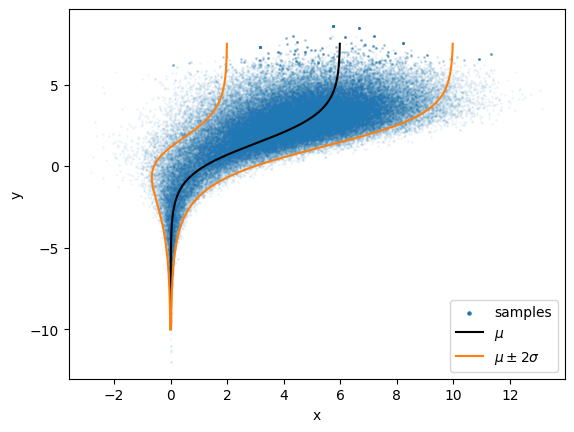

In [8]:
# analytically recover funnel
y_vals = jnp.linspace(-10, 7.5, 1000)
hyper_prior_mean = jnp.zeros_like(y_vals)
hyper_prior_variance = jnp.exp(y_vals)
likelihood_variance = jnp.ones_like(y_vals) * 4.
likelihood_mean = jnp.ones_like(y_vals) * 6.
funnel_variance = (1. / hyper_prior_variance + 1. / likelihood_variance)**(-1)
funnel_mean = (likelihood_mean * hyper_prior_variance + hyper_prior_mean * likelihood_variance) / (hyper_prior_variance + likelihood_variance)


plt.scatter(*samples.T, color='C0', s=1, alpha=0.05)
plt.scatter([], [], label='samples', color='C0', s=5)
plt.plot(funnel_mean, y_vals, color='k', label=r'$\mu$')
plt.plot(funnel_mean + 2. * jnp.sqrt(funnel_variance), y_vals, color='C1')
plt.plot(funnel_mean - 2. * jnp.sqrt(funnel_variance), y_vals, color='C1', label=r'$\mu \pm 2\sigma$')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

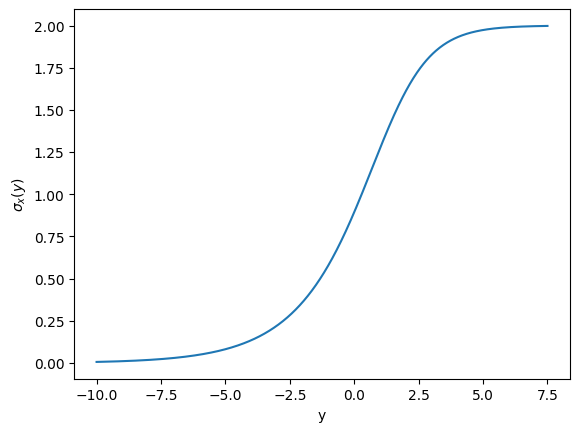

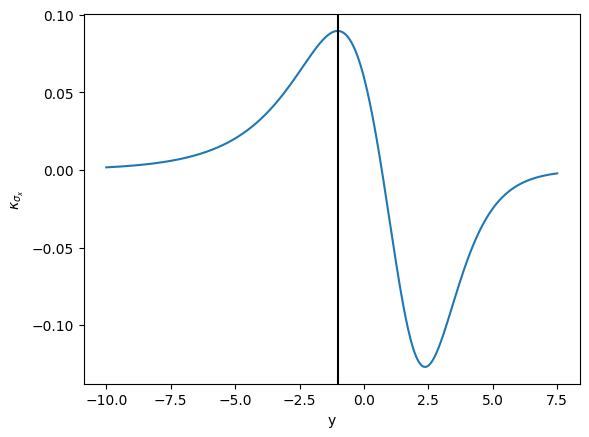

In [9]:
@jit
def get_var(y):
    funnel_variance = (1. / jnp.exp(y) + 1. / 4.)**(-1)
    # funnel_mean = 6. * jnp.exp(y) / (jnp.exp(y) + 4.)
    return jnp.sqrt(funnel_variance)
vectorized_get_var = jit(vmap(get_var))

@jit
def get_lnvar(y):
    return jnp.log(get_var(y))

plt.plot(y_vals, get_var(y_vals))
plt.xlabel('y')
plt.ylabel(r'$\sigma_x (y)$')
plt.show()

d_lnvar = jit(vmap(grad(get_var)))
dd_lnvar = jit(vmap(hessian(get_var)))
kappa = dd_lnvar(y_vals) / (1. + d_lnvar(y_vals)**2.)**(1.5)
y_max_kappa = y_vals[jnp.argmax(kappa)]

plt.plot(y_vals, kappa)
plt.axvline(y_max_kappa, color='k')
plt.xlabel('y')
plt.ylabel(r'$\kappa_{\sigma_x}$')
plt.show()

In [10]:
def conditional_std_kde(x, y, query_points, bandwidth=None):
    """
    Compute conditional standard deviation of x given y using a Gaussian kernel.

    Parameters
    ----------
    x : array_like, shape (n,)
        Samples of the variable of interest.
    y : array_like, shape (n,)
        Samples of the conditioning variable.
    query_points : array_like
        Values of y at which to estimate std(x).
    bandwidth : float or None
        Gaussian kernel bandwidth. If None, uses Silverman's rule.

    Returns
    -------
    stds : ndarray, shape (len(query_points),)
        Conditional standard deviation of x at each query point.
    """
    x = jnp.asarray(x)
    y = jnp.asarray(y)
    query_points = jnp.asarray(query_points)

    n = len(y)
    if bandwidth is None:
        # Silverman's rule of thumb for 1D
        std_y = jnp.std(y, ddof=1)
        bandwidth = 1.06 * std_y * n ** (-1/5)

    stds = []
    for q in query_points:
        # Gaussian weights
        w = jnp.exp(-0.5 * ((y - q) / bandwidth) ** 2)
        w /= jnp.sum(w) + 1e-12  # normalize and avoid divide-by-zero

        mean_x = jnp.sum(w * x)
        var_x = jnp.sum(w * (x - mean_x) ** 2)
        stds.append(jnp.sqrt(var_x))

    return jnp.array(stds)

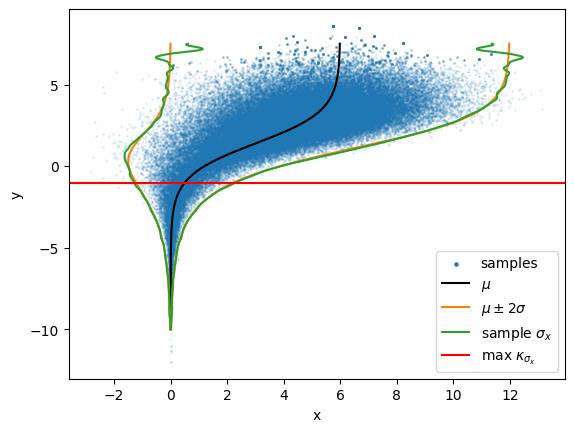

In [11]:
plt.scatter(*samples.T, color='C0', s=1, alpha=0.1)
plt.scatter([], [], label='samples', color='C0', s=5)
plt.plot(funnel_mean, y_vals, color='k', label=r'$\mu$')
plt.plot(funnel_mean + 3. * jnp.sqrt(funnel_variance), y_vals, color='C1')
plt.plot(funnel_mean - 3. * jnp.sqrt(funnel_variance), y_vals, color='C1', label=r'$\mu \pm 2\sigma$')
sigmas = conditional_std_kde(samples[:, 0], samples[:, 1], y_vals, 0.15)
plt.plot(funnel_mean + 3. * sigmas, y_vals, color='C2')
plt.plot(funnel_mean - 3. * sigmas, y_vals, color='C2', label=r'sample $\sigma_x$')
plt.axhline(y_max_kappa, color='r', label=r'max $\kappa_{\sigma_x}$')
plt.xlabel('x')
plt.ylabel('y')
plt.legend(loc='lower right')
plt.show()

In [12]:
# get condition number of Fisher matrix over funnel
@jit
def get_cond(arr):
    Fisher = -hessian(joint_lnpdf)(arr)
    return jnp.linalg.cond(Fisher)
vectorize_get_cond = jit(vmap(get_cond))

vectorize_joint_lnpdf = jit(vmap(joint_lnpdf))

In [13]:
print(grad(get_cond)(jnp.ones(2)))

[ 30.807655 -39.925068]


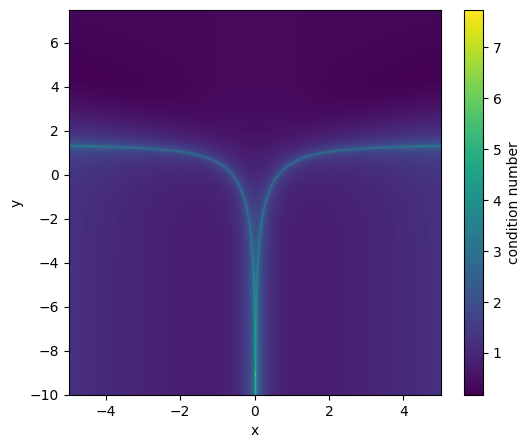

In [14]:
x_min, x_max = (-5., 5.)

# Create grid
n = y_vals.shape[0]
m = y_vals.shape[0]
x = jnp.linspace(x_min, x_max, n)
y = y_vals
X, Y = jnp.meshgrid(x, y, indexing="xy")

# Flatten grid for likelihood evaluation
points = jnp.stack([X.flatten(), Y.flatten()], axis=1)

# Evaluate likelihood
Z = vectorize_get_cond(points)  # shape (n*m,)
logZ = jnp.log10(Z).reshape(n, m)

flat_idx = jnp.argmax(logZ)

# Convert to 2D indices (row, col)
iy, ix = jnp.unravel_index(flat_idx, logZ.shape)

# Map to actual coordinate values
x_max_cond = x[ix]
y_max_cond = y[iy]

# Plot heatmap
plt.figure(figsize=(6, 5))
im = plt.imshow(logZ, origin='lower',
                extent=(x_min, x_max, y_vals[0], y_vals[-1]),
                aspect='auto', cmap='viridis')
# plt.axvline(x_max_cond, color='w')
# plt.axhline(y_max_cond, color='w')
plt.colorbar(im, label='condition number')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

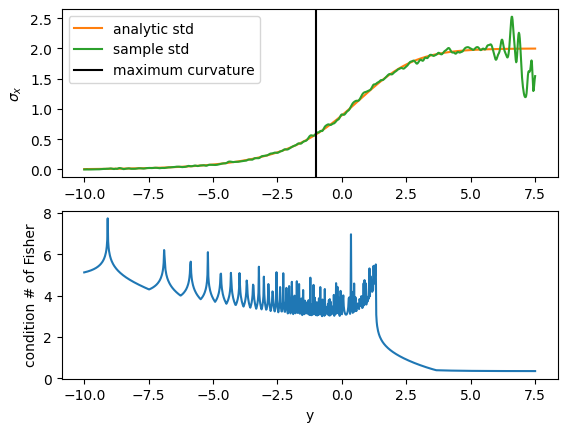

In [19]:
fig, ax = plt.subplots(2, 1)
ax[0].plot(y_vals, jnp.sqrt(funnel_variance), color='C1', label='analytic std')
sigmas = conditional_std_kde(samples[:, 0], samples[:, 1], y_vals, 0.05)
ax[0].plot(y_vals, sigmas, color='C2', label='sample std')
ax[0].axvline(y_max_kappa, color='k',  label='maximum curvature')
ax[0].set_ylabel(r'$\sigma_x$')
ax[0].legend()
ax[1].plot(y_vals, jnp.max(logZ, axis=1))
ax[1].set_ylabel('condition # of Fisher')
plt.xlabel('y')
plt.show()

Now we transform our parameters. Instead of sampling over $y$ which leads to a strong funnel, we sample over $\log_{10}z$ where $z = e^{y / 2}$.

In [20]:
@jit
def extended_lnpdf(arr):
    x, log10_z = arr
    hyper_lnprior_val = js.stats.norm.logpdf(x, loc=0., scale=10**log10_z)
    lnlike_val = lnlike(x)
    return hyper_lnprior_val + lnlike_val
    # return jnp.sum(js.stats.norm.logpdf(arr, loc=jnp.zeros(2), scale=jnp.array([1.e-3, 1.e5])))

@jit
def get_cond_extended(arr):
    Fisher = -hessian(extended_lnpdf)(arr)
    return jnp.linalg.cond(Fisher)
vectorize_get_cond_extended = jit(vmap(get_cond_extended))

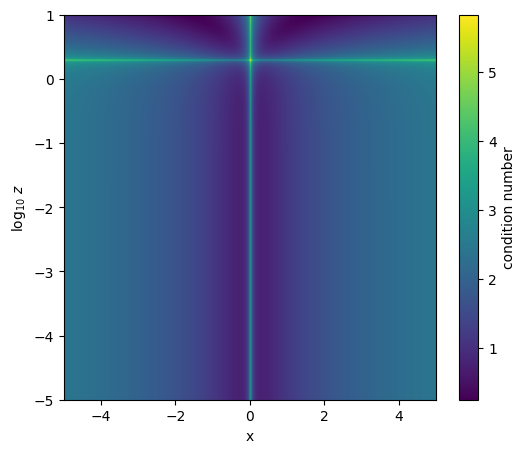

In [21]:
(x_min, x_max), (log10z_min, log10z_max) = ((-5., 5.), (-5, 1))

# Create grid
n = 500
m = 500
x = jnp.linspace(x_min, x_max, n)
y = jnp.linspace(log10z_min, log10z_max, m)
X, Y = jnp.meshgrid(x, y, indexing="xy")

# Flatten grid for likelihood evaluation
points = jnp.stack([X.flatten(), Y.flatten()], axis=1)

# Evaluate likelihood
Z = vectorize_get_cond_extended(points)  # shape (n*m,)
logZ = jnp.log10(Z).reshape(n, m)

flat_idx = jnp.argmax(logZ)

# Convert to 2D indices (row, col)
iy, ix = jnp.unravel_index(flat_idx, logZ.shape)

# Map to actual coordinate values
x_max_cond = x[ix]
y_max_cond = y[iy]

# Plot heatmap
plt.figure(figsize=(6, 5))
im = plt.imshow(logZ, origin='lower',
                extent=(x_min, x_max, log10z_min, log10z_max),
                aspect='auto', cmap='viridis')
# plt.axvline(x_max_cond, color='w')
# plt.axhline(y_max_cond, color='w')
plt.colorbar(im, label='condition number')
plt.xlabel('x')
plt.ylabel(r'$\log_{{{10}}}\,z$')
plt.show()

In [22]:
print(jnp.max(logZ))

5.828441


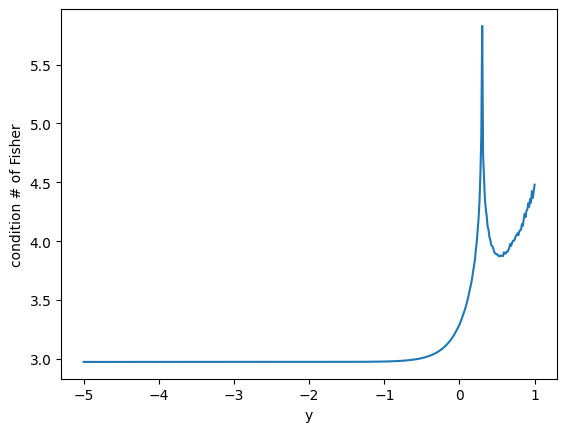

In [24]:
plt.plot(y, jnp.max(logZ, axis=1))
plt.xlabel('y')
plt.ylabel('condition # of Fisher')
plt.show()

In [25]:
from numpyro.infer.initialization import init_to_value

In [26]:
def extended_sampling_model():
    # uniform distribution on z
    log10_z = numpyro.sample('log10_z', dist.Uniform(-15., 15.))
    # conditional prior on x
    x_standard = numpyro.sample('x_standard', dist.Normal())
    x = x_standard * (10. ** log10_z)
    numpyro.deterministic('x', x)
    # x = numpyro.sample('x', dist.Normal(loc=0., scale=10.**log10_z))
    # likelihood
    numpyro.factor('lnlike', lnlike(x))

nuts_kernel_extended = numpyro.infer.NUTS(extended_sampling_model)
mcmc_extended = numpyro.infer.MCMC(sampler=nuts_kernel_extended,
                                      num_warmup=int(1e4),
                                      num_samples=int(1e4))
mcmc_extended.run(jr.key(22))
samples_dict_extended = mcmc_extended.get_samples()
# samples over z instead of y
samples_extended = np.array([samples_dict_extended['x'],
                             samples_dict_extended['log10_z']]).T

sample: 100%|██████████| 20000/20000 [00:05<00:00, 3892.31it/s, 255 steps of size 1.69e-02. acc. prob=0.88]


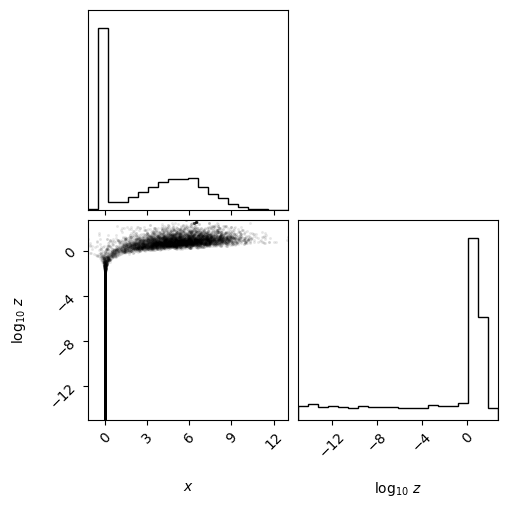

In [27]:
extended_labels = [r'$x$', r'$\log_{10}\,z$']
fig = corner(samples_extended,
             labels=extended_labels,
             plot_contours=False,
             plot_density=False)

In [28]:
import torch
import zuko
import random

In [32]:
log10_z_samples = torch.tensor(samples_extended[:, 1])

In [34]:
# transformation to "normalized" samples
B = 4
max_val = torch.max(log10_z_samples, axis=0).values
min_val = torch.min(log10_z_samples, axis=0).values
h = (max_val - min_val) / 2
mean_val = (max_val + min_val) / 2

def normalize(sample):
    return B * (sample - mean_val) / h

def unnormalize(sample):
    return sample * h / B + mean_val

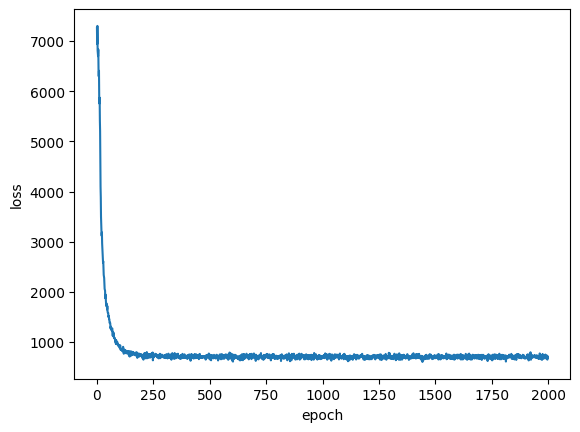

In [35]:
torch.set_default_dtype(torch.float64)

# define flow
flow = zuko.flows.spline.NSF(features=1,
                             context=0,
                             bins=8,
                             passes=2,
                             hidden_features=[512] * 4)

# data used to train flow
normalized_samples = normalize(log10_z_samples).to(torch.float64)

# attributes of training
batch_size = 512
optimizer = torch.optim.Adam(flow.parameters(), lr=1e-3)
losses = []
num_epoch = int(2e4)

# train flow
for epoch in range(num_epoch):

    idx = random.sample(range(normalized_samples.shape[0]), k=batch_size)
    fair_draws = normalized_samples[idx]

    loss = -flow().log_prob(fair_draws).mean()
    loss.backward()

    optimizer.step()
    optimizer.zero_grad()

    # print losses and update progress
    if epoch % 10 == 0:
        print(f'{np.round(epoch / num_epoch * 100, 3)}%   loss = {loss.item()}', end='\r')
        losses.append(loss.item())
plt.plot(losses)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [36]:
normalized_flow_samples = flow().sample((int(1e5),))
flow_samples = unnormalize(normalized_flow_samples)

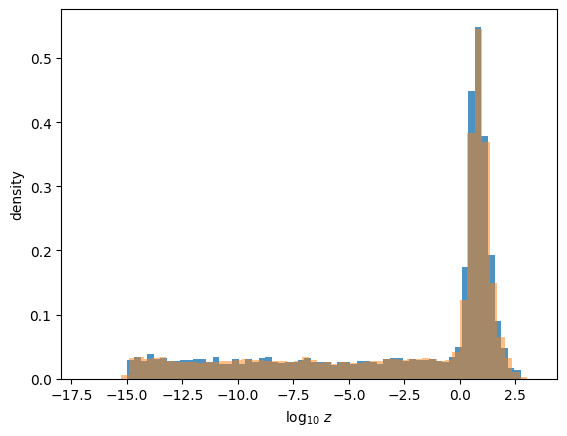

In [37]:
plt.hist(samples_extended[:, 1], density=True,
         bins=60, label='HMC samples', alpha =0.8)
plt.hist(flow_samples, density=True, bins=60,
         label='normalizing flow', alpha=0.5)
plt.xlabel(r'$\log_{10}\,z$')
plt.ylabel('density')
plt.show()

In [38]:
import pyro
import pyro.distributions as pyro_dist

In [40]:
def second_sampling_model():
    y_standard = pyro.sample('y_standard', pyro_dist.Normal(loc=0, scale=1))
    y = pyro.deterministic('y', y_standard * 3.)
    pyro.factor('kde', flow().log_prob(normalize(torch.log10(torch.exp(y / 2.)))))

second_nuts_kernel = pyro.infer.NUTS(model=second_sampling_model)
second_mcmc = pyro.infer.MCMC(kernel=second_nuts_kernel,
                                 warmup_steps=int(5e3),
                                 num_samples=int(1e4))
second_mcmc.run()
y_standard_samples = second_mcmc.get_samples()['y_standard']
y_samples = y_standard_samples * 3.

Sample: 100%|██████████| 15000/15000 [01:14, 202.00it/s, step size=6.64e-01, acc. prob=0.910]


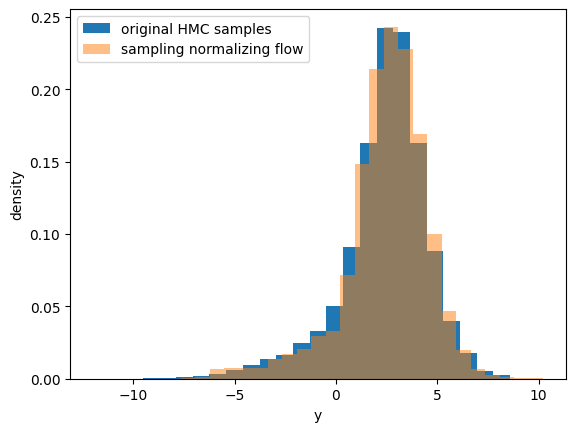

In [44]:
# compare samples of hyper-parameter, y
plt.hist(samples[:, 1], bins=25, label='original HMC samples', density=True)
plt.hist(y_samples[::1], density=True, bins=25, alpha=0.5, label='sampling normalizing flow')
plt.xlabel('y')
plt.ylabel('density')
plt.legend()
plt.show()